# Prediction of total COVID-19 infections in December 2023

#### 1. Nazwa zespołu:
<br> The Overfitting Outliers
#### 2. Członkowie zespołu – imiona, nazwiska i numery indeksu:
<br> Jaźwiński Michał - 124246
<br> Kozłowska Emilia - 123036
<br> Warpas Martyna - 124290

### Packages

In [345]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from datetime import datetime
import lightgbm

from sklearn.metrics import mean_squared_error

### Functions used in further analysis

In [346]:
def features(df):
    
    df_with_feat = df.copy()
    df_with_feat['day_of_week'] = df_with_feat.index.dayofweek
    df_with_feat['quarter'] = df_with_feat.index.quarter
    df_with_feat['month'] = df_with_feat.index.month
    df_with_feat['year'] = df_with_feat.index.year
    df_with_feat['day_of_year'] = df_with_feat.index.dayofyear
    
    return df_with_feat

### Data preparation

In [347]:
# 1. Unzipping file

import zipfile
with zipfile.ZipFile('danehistorycznewojewodztwa.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [348]:
# 2. Scanning folder with data

import os

def scan_folder(parent):
    
    files_list = []
    # iterate over all the files in directory 'parent'
    for file_name in os.listdir(parent):
        if file_name.endswith(".csv"):
            # if it's a txt file, print its name (or do whatever you want)
            files_list.append(file_name)
        else:
            current_path = "".join((parent, "/", file_name))
            if os.path.isdir(current_path):
                # if we're checking a sub-directory, recursively call this method
                scan_folder(current_path)
                
    return files_list


files_list = scan_folder("C:/Users/lenovo/Desktop/MIESI/III semestr/DS_Python")  # Insert parent directory's path


# merging these files into one dataframe

merged_df = pd.DataFrame()

for f in files_list:
        
    day_df = pd.read_csv(f, sep=';', encoding='latin')
    day_df = pd.DataFrame(day_df.head(1))
    day_df['data'] = f[:8]
                
    merged_df = pd.concat([merged_df, day_df])

In [349]:
merged_df[['stan_rekordu_na', 'data']]

,stan_rekordu_na,data
0,2020-11-23,20201124
0,2020-11-24,20201125
0,2020-11-25,20201126
0,2020-11-26,20201127
0,2020-11-27,20201128
...,...,...
0,2023-11-20,20231121
0,2023-11-21,20231122
0,2023-11-22,20231123
0,2023-11-23,20231124


In [350]:
# 3. Preprocessing dataframe with basic data

merged_df = merged_df[['data'
                       , 'liczba_przypadkow'
                       , 'liczba_wszystkich_zakazen']]

merged_df = merged_df.fillna(value=0)
merged_df['liczba_zakazen_total'] = merged_df['liczba_przypadkow'] + merged_df['liczba_wszystkich_zakazen']
merged_df = merged_df[['data', 'liczba_zakazen_total']]

y = merged_df.set_index('data')
y.index = pd.to_datetime(y.index)

In [351]:
y

,liczba_zakazen_total
data,
2020-11-24,10141.0
2020-11-25,15360.0
2020-11-26,16846.0
2020-11-27,17059.0
2020-11-28,15183.0
...,...
2023-11-21,2361.0
2023-11-22,1934.0
2023-11-23,1590.0


### Data exploration

<AxesSubplot:xlabel='data'>

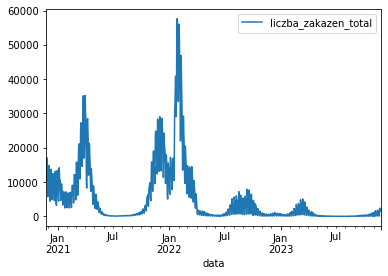

In [352]:
y.plot()

In [353]:
expl_df = features(y)

In [354]:
expl_df

,liczba_zakazen_total,day_of_week,quarter,month,year,day_of_year
data,,,,,,
2020-11-24,10141.0,1,4,11,2020,329
2020-11-25,15360.0,2,4,11,2020,330
2020-11-26,16846.0,3,4,11,2020,331
2020-11-27,17059.0,4,4,11,2020,332
2020-11-28,15183.0,5,4,11,2020,333
...,...,...,...,...,...,...
2023-11-21,2361.0,1,4,11,2023,325
2023-11-22,1934.0,2,4,11,2023,326
2023-11-23,1590.0,3,4,11,2023,327


In [355]:
expl_df.groupby(by=['year', 'month']).agg({'liczba_zakazen_total' : 'sum'})

liczba_zakazen_total
year month                      
2020 11                  91806.0
     12                 304432.0
2021 1                  218147.0
     2                  193609.0
     3                  613627.0
     4                  470300.0
     5                   80591.0
     6                    7542.0
     7                    3044.0
     8                    5787.0
     9                   18409.0
     10                 118133.0
     11                 514444.0
     12                 568168.0
2022 1                  777844.0
     2                  779389.0
     3                  295939.0
     4                   33666.0
     5                   11086.0
     6                    7418.0
     7                   54744.0
     8                  107319.0
     9                  116774.0
     10                  46938.0
     11                  12329.0
     12                  15741.0
2023 1                   10931.0
     2                   40145.0
     3                   76783.0
     4                   17705.0
     5                    3071.0
     6                     940.0
     7                     286.0
     8                     908.0
     9                    4235.0
     10                  10765.0
     11                  26386.0

### Train/test split

In [356]:
# dataframes with one column - target
train = y.loc[y.index <= datetime(2023, 11, 15)]
test = y.loc[y.index > datetime(2023, 11, 15)]

In [357]:
train

,liczba_zakazen_total
data,
2020-11-24,10141.0
2020-11-25,15360.0
2020-11-26,16846.0
2020-11-27,17059.0
2020-11-28,15183.0
...,...
2023-11-11,1012.0
2023-11-12,113.0
2023-11-13,77.0


### Creating some features

In [358]:
# dataframes with target and features
train_df = features(train)
test_df = features(test)

In [359]:
train_df

,liczba_zakazen_total,day_of_week,quarter,month,year,day_of_year
data,,,,,,
2020-11-24,10141.0,1,4,11,2020,329
2020-11-25,15360.0,2,4,11,2020,330
2020-11-26,16846.0,3,4,11,2020,331
2020-11-27,17059.0,4,4,11,2020,332
2020-11-28,15183.0,5,4,11,2020,333
...,...,...,...,...,...,...
2023-11-11,1012.0,5,4,11,2023,315
2023-11-12,113.0,6,4,11,2023,316
2023-11-13,77.0,0,4,11,2023,317


### Building model

In [360]:
# Lists of variables names
X_names = ['day_of_week', 'quarter', 'month', 'year', 'day_of_year']
y_name = ['liczba_zakazen_total']

In [361]:
# Train and test sets - features and target column
X_train = train_df[X_names]
y_train = train_df[y_name]

X_test = test_df[X_names]
y_test = test_df[y_name]

In [362]:
# Looking for best parameters

import numpy as np
from tqdm import tqdm

# Objective function to minimalize mse
def objective(params):
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Parameters space
param_space = {
    'max_depth': range(1, 10),
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight' : range(5, 50, 5),
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'reg_alpha': range(1, 30, 1),
    'reg_lambda': range(1, 30, 1),
    'min_split_loss': range(1, 10)
}

# Number of iterations Random Search
num_iterations = 200

# Initialization of best parameters and best mse
best_params = None
best_mse = np.inf

# Random Search Loop
for iteration in tqdm(range(num_iterations)):
    params = {param: np.random.choice(values) for param, values in param_space.items()}
    mse = objective(params)

    if mse < best_mse:
        best_mse = mse
        best_params = params

# Best parameters for model:
print("Najlepsze parametry:", best_params)
print("Najlepszy logloss:", best_loss)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:28<00:00,  7.06it/s]

Najlepsze parametry: {'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.1, 'min_child_weight': 45, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 11, 'reg_lambda': 10, 'min_split_loss': 4}
Najlepszy logloss: inf


In [363]:
# v1: building model after parameteres optimization

reg_opt = xgb.XGBRegressor(max_depth=5
                           , learning_rate=0.5
                           , gamma=0.1
                           , min_child_weight=10
                           , subsample=0.7
                           , colsample_bytree=0.9
                           , reg_alpha=13
                           , reg_lambda=29
                           , min_split_loss=2)

reg_opt.fit(X_train
            , y_train
            , eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-rmse:7886.10568	validation_1-rmse:1384.94957
[1]	validation_0-rmse:6713.06543	validation_1-rmse:1299.34282
[2]	validation_0-rmse:6256.68091	validation_1-rmse:742.37387
[3]	validation_0-rmse:5162.97443	validation_1-rmse:575.76669
[4]	validation_0-rmse:4950.38120	validation_1-rmse:1651.17292
[5]	validation_0-rmse:4285.33851	validation_1-rmse:1449.73217
[6]	validation_0-rmse:3751.89282	validation_1-rmse:1391.25509
[7]	validation_0-rmse:3576.57612	validation_1-rmse:1160.91752
[8]	validation_0-rmse:3461.66660	validation_1-rmse:1107.28223
[9]	validation_0-rmse:3102.12317	validation_1-rmse:863.36737
[10]	validation_0-rmse:3068.87973	validation_1-rmse:1103.30781
[11]	validation_0-rmse:3020.65952	validation_1-rmse:1063.15044
[12]	validation_0-rmse:2961.22183	validation_1-rmse:1028.30568
[13]	validation_0-rmse:2877.74285	validation_1-rmse:808.77034
[14]	validation_0-rmse:2762.91855	validation_1-rmse:767.21595
[15]	validation_0-rmse:2746.09749	validation_1-rmse:975.81524
[16]	val

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=10, min_split_loss=2, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [364]:
# v2: building model with different parameters
reg = xgb.XGBRegressor(n_estimators=1000
                       , booster='gbtree'
                       , max_depth=15
                       , min_child_weight=0.5
                       , learning_rate=0.01
                       , early_stopping_rounds=50)

reg.fit(X_train
        , y_train
        , eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-rmse:10144.04068	validation_1-rmse:1543.34430
[1]	validation_0-rmse:10052.65024	validation_1-rmse:1539.86529
[2]	validation_0-rmse:9962.16195	validation_1-rmse:1536.41811
[3]	validation_0-rmse:9872.55034	validation_1-rmse:1533.00222
[4]	validation_0-rmse:9784.13950	validation_1-rmse:1529.61759
[5]	validation_0-rmse:9696.25970	validation_1-rmse:1526.26372
[6]	validation_0-rmse:9609.53949	validation_1-rmse:1522.94045
[7]	validation_0-rmse:9523.36344	validation_1-rmse:1519.64748
[8]	validation_0-rmse:9438.05116	validation_1-rmse:1516.38456
[9]	validation_0-rmse:9353.83633	validation_1-rmse:1513.15141
[10]	validation_0-rmse:9270.16599	validation_1-rmse:1509.94765
[11]	validation_0-rmse:9187.06048	validation_1-rmse:1506.77310
[12]	validation_0-rmse:9105.26128	validation_1-rmse:1503.62751
[13]	validation_0-rmse:9023.77085	validation_1-rmse:1500.51056
[14]	validation_0-rmse:8943.07458	validation_1-rmse:1497.42212
[15]	validation_0-rmse:8863.16912	validation_1-rmse:1494.36168


[130]	validation_0-rmse:3279.13878	validation_1-rmse:1216.31871
[131]	validation_0-rmse:3251.72284	validation_1-rmse:1215.25847
[132]	validation_0-rmse:3224.94615	validation_1-rmse:1211.10218
[133]	validation_0-rmse:3198.13160	validation_1-rmse:1210.06372
[134]	validation_0-rmse:3171.74093	validation_1-rmse:1205.95980
[135]	validation_0-rmse:3145.27662	validation_1-rmse:1204.94277
[136]	validation_0-rmse:3119.43793	validation_1-rmse:1200.89308
[137]	validation_0-rmse:3093.46224	validation_1-rmse:1199.89690
[138]	validation_0-rmse:3067.74584	validation_1-rmse:1198.91005
[139]	validation_0-rmse:3042.57989	validation_1-rmse:1194.93573
[140]	validation_0-rmse:3017.19676	validation_1-rmse:1193.96930
[141]	validation_0-rmse:2992.06194	validation_1-rmse:1193.15278
[142]	validation_0-rmse:2967.54150	validation_1-rmse:1189.25222
[143]	validation_0-rmse:2942.88394	validation_1-rmse:1188.31539
[144]	validation_0-rmse:2918.78626	validation_1-rmse:1184.46366
[145]	validation_0-rmse:2894.53578	valid

[259]	validation_0-rmse:1165.48933	validation_1-rmse:938.37238
[260]	validation_0-rmse:1156.84527	validation_1-rmse:936.72774
[261]	validation_0-rmse:1147.79536	validation_1-rmse:936.33723
[262]	validation_0-rmse:1139.13941	validation_1-rmse:935.36678
[263]	validation_0-rmse:1130.23404	validation_1-rmse:935.06055
[264]	validation_0-rmse:1121.91905	validation_1-rmse:933.46058
[265]	validation_0-rmse:1113.17136	validation_1-rmse:933.08317
[266]	validation_0-rmse:1104.95275	validation_1-rmse:931.50637
[267]	validation_0-rmse:1096.35009	validation_1-rmse:931.13539
[268]	validation_0-rmse:1088.29180	validation_1-rmse:929.58157
[269]	validation_0-rmse:1079.81871	validation_1-rmse:928.03976
[270]	validation_0-rmse:1071.86886	validation_1-rmse:927.09055
[271]	validation_0-rmse:1063.54183	validation_1-rmse:925.56993
[272]	validation_0-rmse:1055.69933	validation_1-rmse:924.66583
[273]	validation_0-rmse:1047.69485	validation_1-rmse:923.16601
[274]	validation_0-rmse:1039.57792	validation_1-rmse:92

[391]	validation_0-rmse:446.47175	validation_1-rmse:843.19478
[392]	validation_0-rmse:443.43088	validation_1-rmse:843.12503
[393]	validation_0-rmse:440.44676	validation_1-rmse:843.05586
[394]	validation_0-rmse:437.44614	validation_1-rmse:842.94445
[395]	validation_0-rmse:434.46293	validation_1-rmse:842.83374
[396]	validation_0-rmse:431.54025	validation_1-rmse:842.72377
[397]	validation_0-rmse:428.59884	validation_1-rmse:842.61452
[398]	validation_0-rmse:425.70351	validation_1-rmse:842.50605
[399]	validation_0-rmse:422.83960	validation_1-rmse:842.43002
[400]	validation_0-rmse:419.97260	validation_1-rmse:842.32328
[401]	validation_0-rmse:417.12301	validation_1-rmse:842.21724
[402]	validation_0-rmse:414.31232	validation_1-rmse:842.11195
[403]	validation_0-rmse:411.52816	validation_1-rmse:841.70454
[404]	validation_0-rmse:408.74615	validation_1-rmse:841.63120
[405]	validation_0-rmse:406.01214	validation_1-rmse:841.55841
[406]	validation_0-rmse:403.28600	validation_1-rmse:841.48613
[407]	va

[523]	validation_0-rmse:191.59520	validation_1-rmse:820.32374
[524]	validation_0-rmse:190.47773	validation_1-rmse:820.21849
[525]	validation_0-rmse:189.37051	validation_1-rmse:820.11381
[526]	validation_0-rmse:188.27073	validation_1-rmse:820.00973
[527]	validation_0-rmse:187.18654	validation_1-rmse:819.90485
[528]	validation_0-rmse:186.10039	validation_1-rmse:819.80050
[529]	validation_0-rmse:185.01585	validation_1-rmse:819.69679
[530]	validation_0-rmse:183.94097	validation_1-rmse:819.59364
[531]	validation_0-rmse:182.87558	validation_1-rmse:819.49110
[532]	validation_0-rmse:181.81630	validation_1-rmse:819.38911
[533]	validation_0-rmse:180.76770	validation_1-rmse:819.28771
[534]	validation_0-rmse:179.65248	validation_1-rmse:819.26542
[535]	validation_0-rmse:178.61339	validation_1-rmse:819.16509
[536]	validation_0-rmse:177.57913	validation_1-rmse:819.06537
[537]	validation_0-rmse:176.55490	validation_1-rmse:818.96615
[538]	validation_0-rmse:175.53926	validation_1-rmse:818.86757
[539]	va

[655]	validation_0-rmse:86.94988	validation_1-rmse:808.17847
[656]	validation_0-rmse:86.43882	validation_1-rmse:808.12174
[657]	validation_0-rmse:85.93513	validation_1-rmse:808.06177
[658]	validation_0-rmse:85.42736	validation_1-rmse:808.00578
[659]	validation_0-rmse:84.93033	validation_1-rmse:808.00102
[660]	validation_0-rmse:84.42963	validation_1-rmse:807.94577
[661]	validation_0-rmse:83.93624	validation_1-rmse:807.88973
[662]	validation_0-rmse:83.44567	validation_1-rmse:807.88179
[663]	validation_0-rmse:82.95674	validation_1-rmse:807.87394
[664]	validation_0-rmse:82.47113	validation_1-rmse:807.86613
[665]	validation_0-rmse:81.99290	validation_1-rmse:807.86165
[666]	validation_0-rmse:81.51222	validation_1-rmse:807.85396
[667]	validation_0-rmse:81.03604	validation_1-rmse:807.79954
[668]	validation_0-rmse:80.56476	validation_1-rmse:807.79520
[669]	validation_0-rmse:80.09123	validation_1-rmse:807.74141
[670]	validation_0-rmse:79.62144	validation_1-rmse:807.73462
[671]	validation_0-rmse:

[790]	validation_0-rmse:40.77975	validation_1-rmse:803.54210
[791]	validation_0-rmse:40.56376	validation_1-rmse:803.51183
[792]	validation_0-rmse:40.34786	validation_1-rmse:803.48168
[793]	validation_0-rmse:40.12650	validation_1-rmse:803.45168
[794]	validation_0-rmse:39.91344	validation_1-rmse:803.42183
[795]	validation_0-rmse:39.69919	validation_1-rmse:803.39217
[796]	validation_0-rmse:39.48183	validation_1-rmse:803.36264
[797]	validation_0-rmse:39.27280	validation_1-rmse:803.33326
[798]	validation_0-rmse:39.06498	validation_1-rmse:803.30402
[799]	validation_0-rmse:38.85873	validation_1-rmse:803.27495
[800]	validation_0-rmse:38.64502	validation_1-rmse:803.24601
[801]	validation_0-rmse:38.44114	validation_1-rmse:803.21722
[802]	validation_0-rmse:38.23866	validation_1-rmse:803.18855
[803]	validation_0-rmse:38.03067	validation_1-rmse:803.16005
[804]	validation_0-rmse:37.83007	validation_1-rmse:803.13169
[805]	validation_0-rmse:37.62480	validation_1-rmse:803.10346
[806]	validation_0-rmse:

[925]	validation_0-rmse:20.12219	validation_1-rmse:800.55972
[926]	validation_0-rmse:20.01822	validation_1-rmse:800.54440
[927]	validation_0-rmse:19.91542	validation_1-rmse:800.52914
[928]	validation_0-rmse:19.81256	validation_1-rmse:800.51045
[929]	validation_0-rmse:19.71088	validation_1-rmse:800.49535
[930]	validation_0-rmse:19.60962	validation_1-rmse:800.48032
[931]	validation_0-rmse:19.50884	validation_1-rmse:800.46536
[932]	validation_0-rmse:19.40859	validation_1-rmse:800.45050
[933]	validation_0-rmse:19.30891	validation_1-rmse:800.43570
[934]	validation_0-rmse:19.20977	validation_1-rmse:800.42097
[935]	validation_0-rmse:19.11123	validation_1-rmse:800.40634
[936]	validation_0-rmse:19.01275	validation_1-rmse:800.39174
[937]	validation_0-rmse:18.91573	validation_1-rmse:800.37724
[938]	validation_0-rmse:18.81871	validation_1-rmse:800.36283
[939]	validation_0-rmse:18.72256	validation_1-rmse:800.34846
[940]	validation_0-rmse:18.62680	validation_1-rmse:800.33417
[941]	validation_0-rmse:

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=0.5, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Feature Importance

In [365]:
fi = pd.DataFrame(data=reg.feature_importances_
                 , index=reg.feature_names_in_
                 , columns=['fi'])

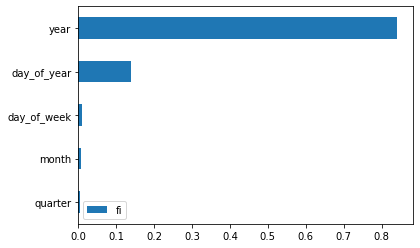

In [366]:
fi.sort_values(by='fi').plot(kind='barh')
plt.show()

### Prediction on train and test sets

In [367]:
# Prediction on train set
train_df['prediction'] = reg.predict(X_train)

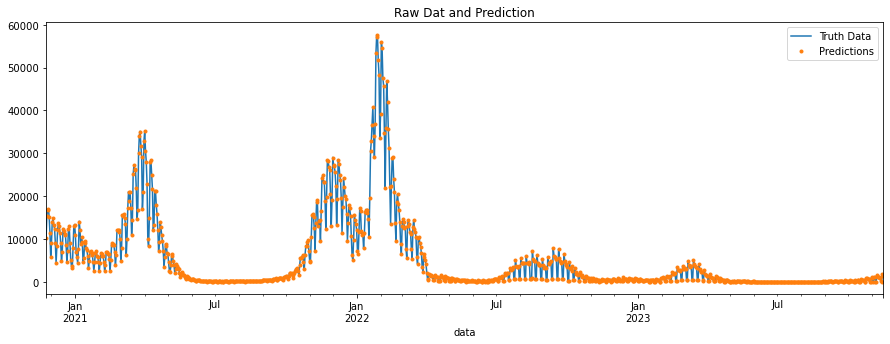

In [368]:
ax = train_df[['liczba_zakazen_total']].plot(figsize=(15, 5))
train_df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [369]:
# Prediction on test set
test_df['prediction'] = reg.predict(X_test)

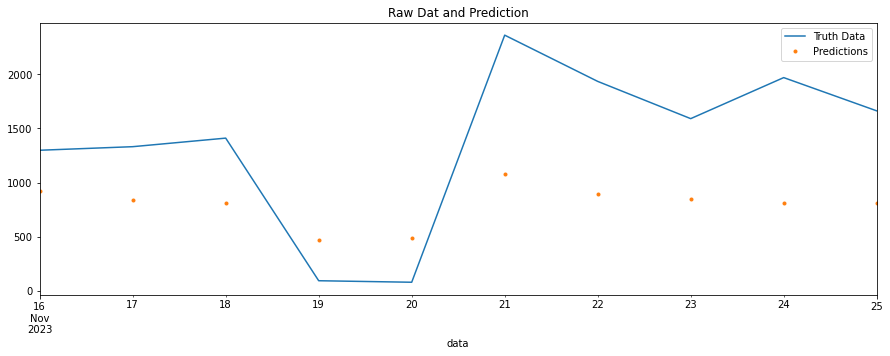

In [370]:
ax = test_df[['liczba_zakazen_total']].plot(figsize=(15, 5))
test_df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

### Prediction on December 2023

In [371]:
dec_date_df = pd.DataFrame({'data' : pd.date_range(start='20231201', end='20231231')})
dec_date_df = dec_date_df.set_index('data')
dec_feat_df = features(dec_date_df)

In [372]:
dec_feat_df['prediction'] = reg.predict(dec_feat_df)

In [373]:
dec_feat_df

,day_of_week,quarter,month,year,day_of_year,prediction
data,,,,,,
2023-12-01,4,4,12,2023,335,873.897705
2023-12-02,5,4,12,2023,336,875.026184
2023-12-03,6,4,12,2023,337,487.035248
2023-12-04,0,4,12,2023,338,489.177887
2023-12-05,1,4,12,2023,339,1173.839111
2023-12-06,2,4,12,2023,340,1027.129761
2023-12-07,3,4,12,2023,341,1007.836609
2023-12-08,4,4,12,2023,342,837.303406
2023-12-09,5,4,12,2023,343,796.483337


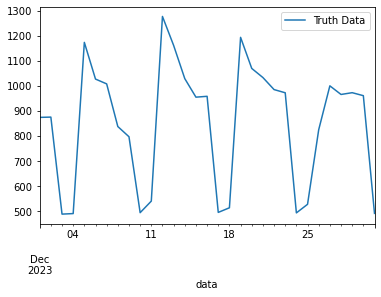

In [374]:
dec_feat_df['prediction'].plot(style='-')
plt.legend(['Truth Data', 'Predictions'])
plt.show()

### Sum of predictions in December 2023:

In [375]:
dec_feat_df['prediction'].sum().round()

26473.0